<a href="https://colab.research.google.com/github/shadeq2022/Belajar-Pengembangan-Machine-Learning/blob/main/Deployment/Image_Classification_Model_Deployment_Dicoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mammals Image Classification**
Nama    : Muhammad Shadeq <br>
Email   : muhammadshadeq25@gmail.com <br>
Dataset : https://www.kaggle.com/datasets/asaniczka/mammals-image-classification-dataset-45-animals

**Import library**

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.densenet import DenseNet201,preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Conv2D,MaxPooling2D,Dense,Lambda
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.utils import get_file

from google.colab import drive
from google.colab import files
import pathlib

In [ ]:
! pip install -q tf-nightly

**API Kaggle dan Download Dataset**

In [ ]:
! pip install kaggle

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/

/content


In [ ]:
!kaggle datasets download -d asaniczka/mammals-image-classification-dataset-45-animals

mammals-image-classification-dataset-45-animals.zip: Skipping, found more recently modified local copy (use --force to force download)


**Lakukan Ekstrak File zip**

In [ ]:
local_zip = '/content/mammals-image-classification-dataset-45-animals.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

**Data Directories**

In [ ]:
img_dir = '/content/mammals'
test_dir = '/content/test/test'

**image size and batch size**

In [ ]:
image_size = 256
batch_size = 30

**Training data**

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=img_dir,
    validation_split=0.2,
    subset="training",
    seed=1000,
    image_size=(image_size,image_size),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 13751 files belonging to 45 classes.
Using 11001 files for training.


In [ ]:
class_names=train_ds.class_names
class_names

['african_elephant',
 'alpaca',
 'american_bison',
 'anteater',
 'arctic_fox',
 'armadillo',
 'baboon',
 'badger',
 'blue_whale',
 'brown_bear',
 'camel',
 'dolphin',
 'giraffe',
 'groundhog',
 'highland_cattle',
 'horse',
 'jackal',
 'kangaroo',
 'koala',
 'manatee',
 'mongoose',
 'mountain_goat',
 'opossum',
 'orangutan',
 'otter',
 'polar_bear',
 'porcupine',
 'red_panda',
 'rhinoceros',
 'sea_lion',
 'seal',
 'snow_leopard',
 'squirrel',
 'sugar_glider',
 'tapir',
 'vampire_bat',
 'vicuna',
 'walrus',
 'warthog',
 'water_buffalo',
 'weasel',
 'wildebeest',
 'wombat',
 'yak',
 'zebra']

**Validation data**

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=img_dir,
    validation_split=0.2,
    subset="validation",
    seed=1000,
    image_size=(image_size,image_size),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 13751 files belonging to 45 classes.
Using 2750 files for validation.


**Test data**

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=(image_size,image_size),
    batch_size=batch_size,
    label_mode='categorical',
)

Found 11 files belonging to 1 classes.


**Visualisasikan (plot) beberapa gambar dari data pelatihan dengan labelnya**

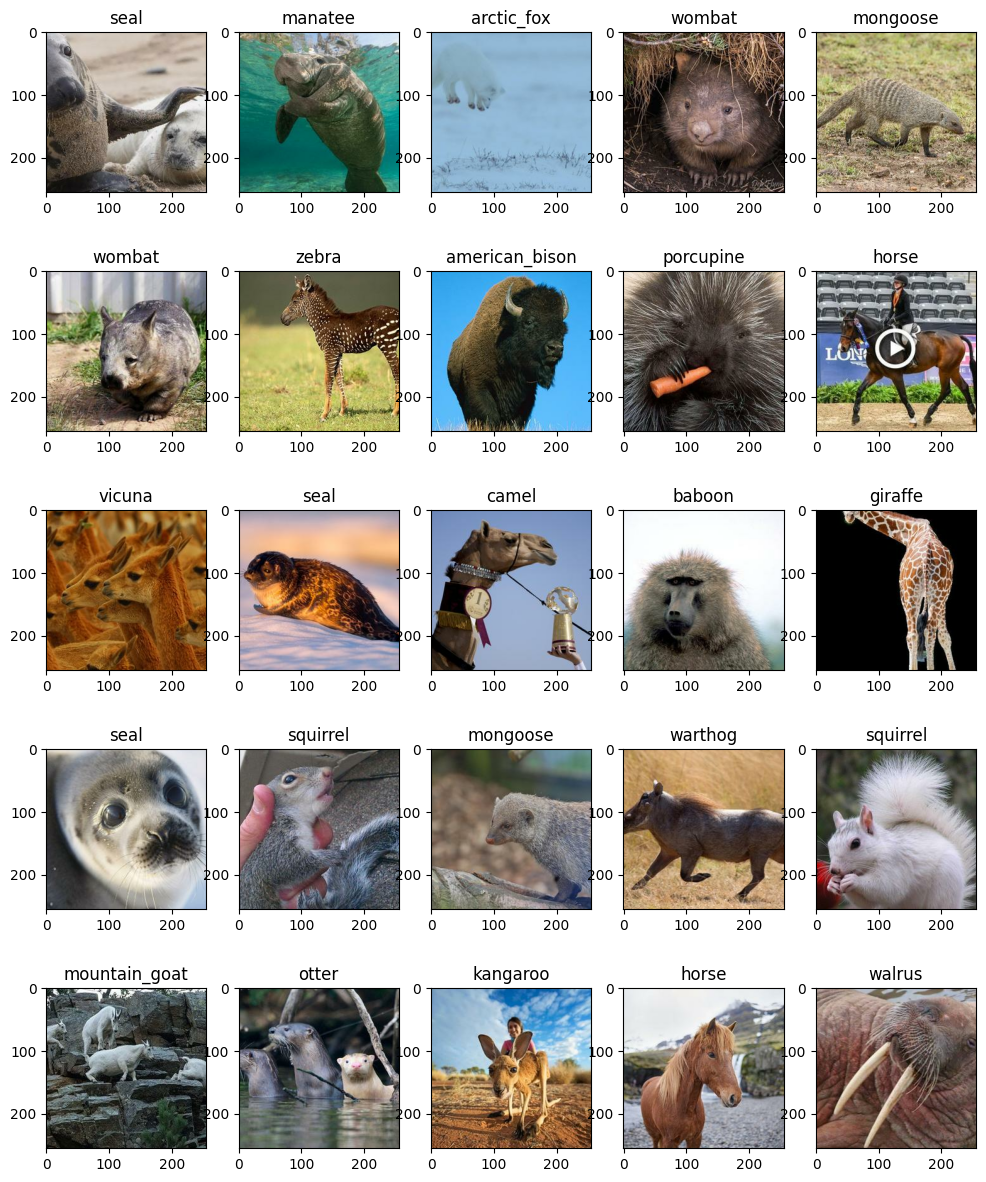

In [ ]:
# x_shape = []
# y_shape = []
plt.figure(figsize=(12,15))
for img,label in train_ds.take(1):
    for i in range(25):
#         x_shape.append(img[i].shape[0])
#         y_shape.append(img[i].shape[1])
        ax = plt.subplot(5,5,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])

**Model**

In [ ]:
base_model = DenseNet201(weights = 'imagenet',
                        include_top = False,
                        input_shape=(image_size,image_size,3))
base_model.trainable = False

In [ ]:
model = Sequential()
model.add(Lambda(preprocess_input,input_shape = (image_size,image_size,3)))
model.add(base_model)
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(64,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(45,activation = 'softmax'))

In [ ]:
model.compile(optimizer='adam',loss = 'CategoricalCrossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 32)          552992    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                 

In [ ]:
class stop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98 and logs.get('val_accuracy')>0.88):
      self.model.stop_training=True
      print("\n Akurasi telah mencapai > 98%!")
callbacks=stop()

In [ ]:
epochs = 45
history = model.fit(train_ds,validation_data=val_ds,epochs = epochs , batch_size=30,callbacks=[callbacks])

Epoch 1/45
367/367 [==============================] - 82s 222ms/step - loss: 0.0554 - accuracy: 0.9832 - val_loss: 0.8395 - val_accuracy: 0.8782
Epoch 2/45
367/367 [==============================] - 81s 221ms/step - loss: 0.0838 - accuracy: 0.9775 - val_loss: 0.7527 - val_accuracy: 0.8902
Epoch 3/45
367/367 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9919
 Akurasi telah mencapai > 98%!
367/367 [==============================] - 81s 220ms/step - loss: 0.0321 - accuracy: 0.9919 - val_loss: 0.7358 - val_accuracy: 0.8956


**Plot accuracy dan error (train dan validation)**

<Axes: >

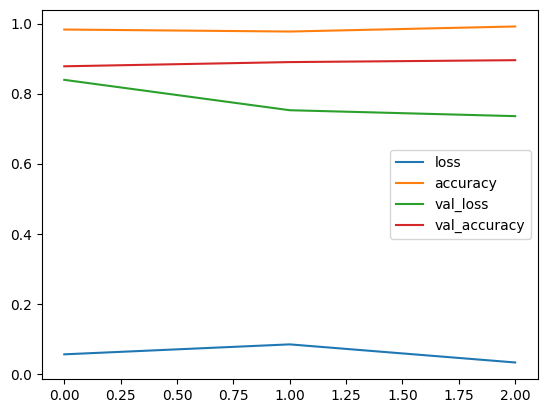

In [ ]:
history = pd.DataFrame(model.history.history)
history.plot()

**Menyimpan model**

In [ ]:
# Menyimpan model dalam format SavedModel
export_dir = '/gdrive/My Drive/Kaggle/saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

74886048

**Testing foto mammals random dari folder test**

In [ ]:
prediction = np.argmax(model.predict(test_ds), axis=-1)
prediction

1/1 [==============================] - 9s 9s/step


array([ 8, 28, 18,  0, 11, 10,  5, 35, 32, 27, 12])

In [ ]:
predictions = []
for i in prediction:
    predictions.append(class_names[i])

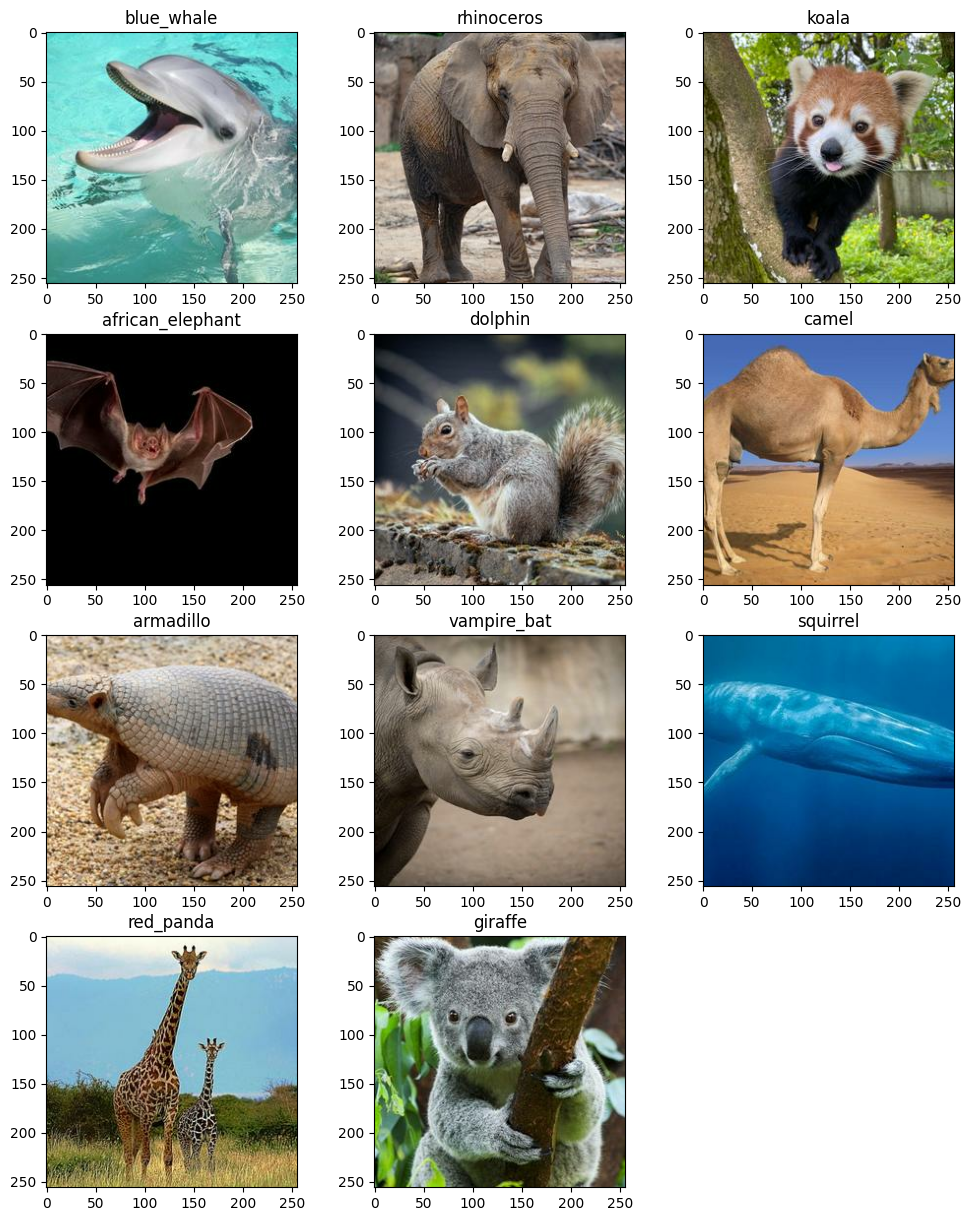

In [ ]:
plt.figure(figsize=(12,15))
for image,label  in test_ds.take(1):
        for i in range(11):
            plt.subplot(4,3,i+1)
            plt.imshow(image[i].numpy().astype("uint8"))
            plt.title(predictions[i])